# Reference Designs

## Image Classification with Transfer Learning

### Data Processing

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

In [2]:
# download data
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://pytorch.tips/bee-zip'
with urlopen(zipurl) as zippresp:
    with ZipFile(BytesIO(zippresp.read())) as zfile:
        zfile.extractall('./data/bee')

In [3]:
# define transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [4]:
# define datasets
train_dataset = datasets.ImageFolder(
    root='./data/bee/hymenoptera_data/train/',
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root='./data/bee/hymenoptera_data/val/',
    transform=val_transforms
)

In [5]:
# define our dataloaders for batch iteration
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4
)

### Model Design

In [6]:
model = models.resnet18(pretrained=True)

# we read the number of features before the final layer
print(model)
print(model.fc)

/Users/woojin/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/woojin/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# we change the final layer by directly setting `model.fc` to a fully connected layer with two outputs
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
print(model.fc)

Linear(in_features=512, out_features=2, bias=True)


### Training and Validation

In [8]:
from torch.optim.lr_scheduler import StepLR

# device = torch.device(
#     'mps' if torch.backends.mps.is_available()
#     else 'cpu'
# )

device = torch.device('cpu')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

# we use a scheduler from PyTorch to adjust the learning rate of our SGD optimizer after several epochs
exp_lr_scheduler = StepLR(optimizer,
                          step_size=7,
                          gamma=0.1)

In [9]:
# trainning and validation loop
num_epochs = 25

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(labels)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() / inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)
    
    # schedule the learinig rate for next epoch of training    
    exp_lr_scheduler.step()
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() / inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) / inputs.size(0)
            
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects / len(val_loader)
    
    print("Train - Loss: {:.4f} Acc: {:.4f}"
          "Val - Loss: {:.4f} Acc: {:.4f}"
          .format(train_epoch_loss, train_epoch_acc,
                  epoch_loss, epoch_acc))

Train - Loss: 0.1432 Acc: 0.6844Val - Loss: 0.0488 Acc: 0.9487
Train - Loss: 0.1139 Acc: 0.7664Val - Loss: 0.0751 Acc: 0.8974
Train - Loss: 0.1278 Acc: 0.8033Val - Loss: 0.0648 Acc: 0.9103
Train - Loss: 0.0947 Acc: 0.8361Val - Loss: 0.0911 Acc: 0.8782
Train - Loss: 0.1363 Acc: 0.7869Val - Loss: 0.0788 Acc: 0.8974
Train - Loss: 0.1345 Acc: 0.8033Val - Loss: 0.0783 Acc: 0.8974
Train - Loss: 0.0978 Acc: 0.8320Val - Loss: 0.0817 Acc: 0.8654
Train - Loss: 0.0738 Acc: 0.8893Val - Loss: 0.0509 Acc: 0.9359
Train - Loss: 0.0727 Acc: 0.8811Val - Loss: 0.0528 Acc: 0.9231
Train - Loss: 0.0753 Acc: 0.8893Val - Loss: 0.0538 Acc: 0.9295
Train - Loss: 0.0980 Acc: 0.8525Val - Loss: 0.0494 Acc: 0.9295
Train - Loss: 0.0685 Acc: 0.8811Val - Loss: 0.0988 Acc: 0.9103
Train - Loss: 0.0724 Acc: 0.8852Val - Loss: 0.0825 Acc: 0.9103
Train - Loss: 0.0807 Acc: 0.8484Val - Loss: 0.0461 Acc: 0.9231
Train - Loss: 0.0497 Acc: 0.9139Val - Loss: 0.0810 Acc: 0.9103
Train - Loss: 0.0611 Acc: 0.8975Val - Loss: 0.0483 Acc:

### Testing and Deployment

In [10]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    # Switch from C x H x W to H x W x C image for mats plotting
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # undo the normalization we do during transforms so we can properly view images
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


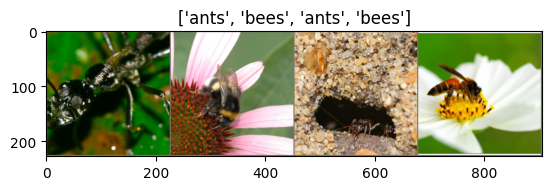

In [11]:
inputs, classes = next(iter(val_loader))

out = torchvision.utils.make_grid(inputs)
class_names = val_dataset.classes

outputs = model(inputs.to(device))
_, preds = torch.max(outputs, 1)

imshow(out, title=[class_names[x] for x in preds])

# Sentiment Analysis with Torchtext

## Data Processing

In [139]:
# we will use bi-grams, which are pairs of words or tokens that appear in a sentence
def generate_bigram(x):
    # select two words 
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    # print(n_grams)
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    
    return x

In [140]:
generate_bigram(['This', 'movie', 'is', 'awesome'])

['This', 'movie', 'is', 'awesome', 'movie is', 'is awesome', 'This movie']

In [141]:
from torchtext.datasets import IMDB
from torch.utils.data.dataset import random_split
from torchtext import data, datasets

TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

# load data from IMDB dataset
# train_iter, test_iter = IMDB(
#     split=('train', 'test')
# )
train_iter, test_iter = IMDB.splits(
    TEXT, LABEL
)


# redefine iterators as lists
train_dataset = list(train_iter)
test_data = list(test_iter)

# split training data into two sets, 70% for training and 30% for validation
num_train = int(len(train_dataset) * 0.70)
train_data, valid_data = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train]
)

In [142]:
print(len(train_data), len(valid_data), len(test_data))

17500 7500 25000


In [143]:
print(train_iter.fields)

{'text': <torchtext.data.field.Field object at 0x2fdd835e0>, 'label': <torchtext.data.field.Field object at 0x2fdd830d0>}


In [144]:
data_index = 21
print(train_data[data_index].label)

neg


In [145]:
print(train_data[data_index].text)

['this', 'movie', 'goes', 'beyond', 'just', 'being', 'bad,', 'it', 'is', 'definitively', 'the', 'worst', 'movie', 'i', 'have', 'ever', 'seen', 'in', 'my', 'entire', 'life.', 'unless', 'you', 'yourself', 'have', 'a', 'problem', 'with', 'necrophilia', 'than', 'you', 'will', 'not', 'enjoy', 'will', 'not', 'enjoy', 'the', 'scenes', 'depicting', 'it', 'in', 'this', 'film,', '(if', 'you', 'can', 'call', 'it', 'that).']


In [146]:
# for fixing error
# OSError: [E941] Can't find model 'en'. It looks like you're trying to load a model from a shortcut, which is obsolete as of spaCy v3.0. To load the model, use its full name instead:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [147]:
import spacy
nlp= spacy.load('en_core_web_sm')

In [148]:
train_data

In [149]:
# train_data Exple attribute 1) label : 0 or 1 int, 2) text : string list ['bizarre', 'tobe', ...]
# list ot string `join` fucntion
' '.join(train_data[1].text)

'it\'s pretty clear that the director and production crew set out to paint a less than flattering picture of the palestinian girl and her family. the film and it\'s website tries to imply that ayat has a secret reason for blowing herself and rachel up- a boyfriend problem- perhaps pregnancy. neatly glossed over is the fact that ayat had herself just witnessed the death of a close friend at the hands of the israelis\'-just outside her home. gosh,so why on earth would a young, pretty, intelligent girl with plans for college go and do such a thing? could it be that the hormonal, emotional teenager was traumatized by seeing seeing someone she loved die before her very eyes? this detail merits all of 5 seconds in the movie. another neatly sidestepped detail is that avigail levy, rachels\' mother, could have prevented the destruction of the building the akhras family lived in(along with 22 other families). one distinctly gets the impression that she\'s offering this as a "concession" - shoul

In [150]:
# The data pipeline will use our `generate_bigrams()` function, a tokenizer, and a vocabulry
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torch

# We specify `spaCy` as the tokenizer
# spaCy is a popular Python package for NLP and induces its own tokenizer
tokenizer = get_tokenizer('spacy')
counter = Counter()

for _, line in enumerate(train_data):
    # make a list of all tokens used in the training data and count how many times each occurs
    counter.update(generate_bigram(tokenizer(' '.join(line.text))))

# A vocabulary is just a set of words that we can use
# if we find a word in the movie review that is not contrined in the vocabulary, we set the word to a special word called "unknown"
# we limit our dictionary to 25,000 words, much smaller than the full set of words in the English language
# we specify our vocabulary vectors called GloVe(Gloabal Vector for Word Representation) with 100 dimensions
# An embedding is a method to map a word or series of words to a numeric vector
vocab = Vocab(counter,
              max_size=25000,
              vectors= "glove.6B.100d",
              unk_init=torch.Tensor.normal_)

In [151]:
# we build out data pipeline for the review and label text data

text_pipeline = lambda x : [vocab[token] for token in generate_bigram(tokenizer(x))]
label_pipeline = lambda x : 1 if x=='pos' else 0

In [152]:
print(text_pipeline('the movie was horrible'))

[2, 23, 19, 816, 12885, 545, 143]


In [153]:
print(label_pipeline('neg'))

0


In [154]:
# we define out datasets and preprocessing, creating dataloaders

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = 'cpu'
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

def collate_batch(batch):
    label_list, text_list = [], []
    for data in batch:
        label_list.append(label_pipeline(data.label))
        processed_text = torch.tensor(text_pipeline(' '.join(data.text)))
        text_list.append(processed_text)
    
    return (
        torch.tensor(label_list, dtype=torch.float64).to(device), 
        pad_sequence(text_list, padding_value=1.0).to(device)
        )

# batch_size = 64
# def batch_sampler():
#     indices = [(i, len(tokenizer(' '.join(s.text)))) for i, s in enumerate(train_dataset)]

BATCH_SIZE = 64

train_dataloder = DataLoader(
    train_data,
    collate_fn=collate_batch,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)

## Model Design

In [155]:
# We will use a model called FastText

import torch.nn as nn 
import torch.nn.functional as F 

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=pad_idx
        )
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        # embedding for each word using the `nn.Embedded` layer
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2)
        # it calculates the average of all the word embeddings with `avg_pool2d()` function
        pooled = F.avg_pool2d(
            embedded,
            (embedded.shape[1], 1)
        ).squeeze(1)
        # it feeds the average through a linear layer. 
        return self.fc(pooled)

In [156]:
model = FastText(
    vocab_size= len(vocab),
    embedding_dim= 100,
    output_dim= 1,
    pad_idx= vocab['<PAD>']
)

In [157]:
# we initialize the layer's weights with pretrained embeddings

# load the pretrained embedding from our vocabulary
pretrained_embeddings = vocab.vectors
# initialize the embedding layer's weights
model.embedding.weight.data.copy_(pretrained_embeddings)

EMBEDDING_DIM = 100

# Initialize the embedding weights of an unknown token to zero
unk_idx = vocab['<UNK>']

# Initialize the embedding weights of a pad token to zero
pad_idx = vocab['<PAD>']

model.embedding.weight.data[unk_idx] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[pad_idx] = torch.zeros(EMBEDDING_DIM) 

## Training and Validation

In [158]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()      # commonly used for binary classification

In [159]:
for epoch in range(5):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for label, text in train_dataloder:
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, label)
        
        rounded_pred = torch.round(
            torch.sigmoid(predictions)
        )
        
        correct = (rounded_pred == label).float()
        acc = correct.sum() / len(correct)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print("Epoch %d Train - Loss: %.4f Acc: %.4f" % (epoch, epoch_loss/len(train_dataloder), epoch_acc/len(train_dataloder)))
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for label, text in valid_dataloader:
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, label)
            rounded_pred = torch.round(
                torch.sigmoid(predictions)
            )
            correct = (rounded_pred == label).float()
            acc = correct.sum() / len(correct)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    print("Epoch %d Valid - Loss: %.4f Acc: %.4f" % (epoch, epoch_loss/len(valid_dataloader), epoch_acc/len(valid_dataloader)))

Epoch 0 Train - Loss: 0.6923 Acc: 0.5156
Epoch 0 Valid - Loss: 0.6887 Acc: 0.5306
Epoch 1 Train - Loss: 0.6840 Acc: 0.5697
Epoch 1 Valid - Loss: 0.6773 Acc: 0.5964
Epoch 2 Train - Loss: 0.6651 Acc: 0.6941
Epoch 2 Valid - Loss: 0.6542 Acc: 0.6597
Epoch 3 Train - Loss: 0.6324 Acc: 0.7549
Epoch 3 Valid - Loss: 0.6185 Acc: 0.7795
Epoch 4 Train - Loss: 0.5920 Acc: 0.7816
Epoch 4 Valid - Loss: 0.5798 Acc: 0.7916


## Testing and Deployment

In [162]:
test_loss = 0
test_acc = 0
model.eval()

with torch.no_grad():
    for label, text in test_dataloader:
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, label)
        
        rounded_pred = torch.round(
            torch.sigmoid(predictions)
        )
        
        correct = (rounded_pred == label).float()
        acc = correct.sum() / len(correct)
        
        test_loss += loss.item()
        test_acc += acc.item()
        
print("Test - Loss: %.4f Acc: %.4f" % (test_loss/len(test_dataloader), test_acc/len(test_dataloader)))

Test - Loss: 0.5801 Acc: 0.7925


In [164]:
# We will predict the sentiment of our own reviews

import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    with torch.no_grad():
        text = torch.tensor(text_pipeline(sentence)).unsqueeze(1).to(device)
        prediction = torch.sigmoid(model(text))
        return prediction.item()

In [174]:
import numpy as np
sentiment_1 = predict_sentiment(model, "Don't waste your time")
print(sentiment_1)

9.079296425795746e-09


In [178]:
sentiment_2 = predict_sentiment(model, "You gotta see this movie!")
print(sentiment_2)

0.0


In [179]:
torch.save(model.state_dict(), './models/fasttext_model.pt')

# Generative Learning - Generating Fashion-MNIST Images with DCGAN